<H2>Data Overview</H2>
In this competition, we need to predict if two people share a kinship relationship or not based on their facial images. The data is provided by Families In the Wild (FIW), the largest and most comprehensive image database for automatic kinship recognition.

FIW's dataset is obtained from publicly available images from celebrities.

<H2>File Descriptions </H2>

*   train-faces.zip - the training set is divided in Families (F0123), then individuals (MIDx). Images in the same MIDx folder belong to the same person. Images in the same F0123 folder belong to the same family.

* train.csv - training labels. Remember, not every individual in a family shares a kinship relationship. For example, a mother and father are kin to their children, but not to each other.

* test-faces.zip - the test set contains face images of unknown individuals

* sample_submission.csv - a sample submission file in the correct format. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg. Your goal is to predict if each pair of images in test-faces are related or not, where 1 means related and 0 means unrelated.
   



<H1>Evalutaion</h1>
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. Not all pairs will be scored.

In [0]:
from collections import defaultdict
from glob import glob
from random import choice, sample
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

<h1>Uploading Kaggle credentials 

In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


<H1>Downloading the Dataset

In [0]:
!kaggle competitions download -c recognizing-faces-in-the-wild

  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 31.4MB/s]
 64% 22.0M/34.1M [00:00<00:00, 46.3MB/s]
100% 34.1M/34.1M [00:00<00:00, 113MB/s] 
 89% 61.0M/68.6M [00:00<00:00, 62.4MB/s]
100% 68.6M/68.6M [00:00<00:00, 101MB/s] 
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 48.3MB/s]


In [0]:
%%time
%%capture
!unzip test.zip -d test 

CPU times: user 335 ms, sys: 48.6 ms, total: 384 ms
Wall time: 3.57 s


In [0]:
import os
print("The no of test images:",len(os.listdir('test')))

The no of test images: 6282


In [0]:
%%time
%%capture
!unzip train.zip -d train

CPU times: user 2.03 s, sys: 242 ms, total: 2.28 s
Wall time: 5.5 s


In [0]:
print("The no of train images:",len(os.listdir('test')))
# here it contains both the folders and pics

The no of train images: 6282


<H1>Exploratory Data Analysis

In [0]:
train_file_path = "train_relationships.csv"
train_folders_path = "train/"
train_df=pd.read_csv('train_relationships.csv')
sample_sub_df=pd.read_csv('sample_submission.csv')
val_famillies = "F09"
# The above cell contain only the variables which we change in future

In [0]:
all_images = glob(train_folders_path + "*/*/*.jpg")
print("Total no images inside all the folders : ",len(all_images))

Total no images inside all the folders :  12379


In [0]:
family_folder_names = [x for x in os.listdir(train_folders_path) if 'F' in x]
print("Total no of families :",len(family_folder_names))

Total no of families : 470


understanding sample submission

In [0]:
sample_sub_df.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


understanding training data

In [0]:
train_df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [0]:
train_df.shape

(3598, 2)

Understanding the family count 

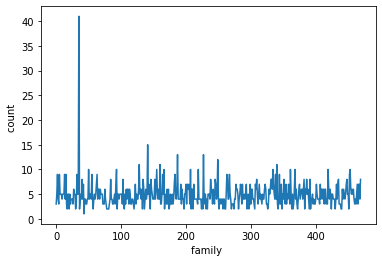

In [0]:
family_count = [len(os.listdir(train_folders_path+'/'+f)) for f in family_folder_names]
# observing the family count and its distribution
plt.plot(list(range(len(family_count))), family_count)
plt.xlabel("family ")
plt.ylabel("count ")
plt.show()
# family_count

We can see that only 1 family as 40 members and remaining family have less than 15 members

In [0]:
print("The minimum family count is :",min(family_count))
print("The no of families with minimum family count are :",family_count.count(min(family_count)))
print("The maximum family count is :",max(family_count))
print("The no of families with minimum family count are :",family_count.count(max(family_count)))

The minimum family count is : 1
The no of families with minimum family count are : 1
The maximum family count is : 41
The no of families with minimum family count are : 1


In [0]:
samp_fam_path = train_folders_path+family_folder_names[2]
samp_img_path = os.listdir(samp_fam_path)[1]
len(os.listdir(samp_fam_path +"/"+ samp_img_path))

10

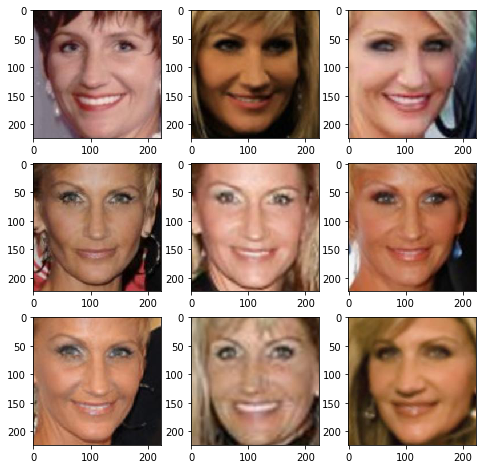

In [0]:
import matplotlib.image as mpimg

# plotting multiple imagees
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
img_path = samp_fam_path +"/"+ samp_img_path +"/"
files=os.listdir(img_path)
try:
    for i in range(1, columns*rows +1):
    # print(img_path+files[i])
        img = mpimg.imread(img_path+files[i],0)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
except:
    pass    

In [0]:
import cv2
img = cv2.imread(img_path+files[0])
# height, width, channels = 
img.shape

(224, 224, 3)

In [0]:
print("Checking NaN values : \n",train_df.isna().sum())

Checking NaN values : 
 p1    0
p2    0
dtype: int64


<H1>Training of Data

In [0]:
train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]
train_person_to_images_map = defaultdict(list)

In [0]:


train_person_to_images_map = defaultdict(list)
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)


# In[31]:


relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]


# In[32]:


train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]


# In[33]:


def read_img(path):
    img = image.load_img(path, target_size=(224, 224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)


# In[34]:


def datagen(list_tuples, person_to_images_map, batch_size=8):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

   


# In[35]:


from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D,MaxPooling1D,GlobalAveragePooling1D,LSTM
from keras.layers import Concatenate, Multiply, Dropout, Subtract, Add, Conv2D,Conv1D
from keras.models import Model
from keras.layers import BatchNormalization,Reshape
from keras.preprocessing import image
from keras.optimizers import Adam,SGD,rmsprop
import h5py
from keras.regularizers import l2
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.layers import LeakyReLU
from keras import regularizers
from keras.initializers  import RandomNormal

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


# ![image.png](attachment:image.png)

# In[36]:


def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


# In[37]:



def siamese_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False,input_shape=(224, 224, 3))

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalAvgPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])  
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4  = Subtract()([x1_, x2_])    
    x   = Concatenate(axis=-1)([x4, x3])
    x   = Reshape(input_shape=(8192,), target_shape=(8192, 1))(x)
    
    """    x   = Conv1D(filters=100, kernel_size=3 ,strides=3,input_shape=( 8192,1),dilation_rate = 1,
                  activation= 'relu',kernel_regularizer=l2(1e-5),
                   kernel_initializer='uniform',
                 bias_initializer=initialize_bias)(x)
    x   = Conv1D( 100,3,activation= 'relu', kernel_initializer= 'he_uniform')(x)
    x   = Flatten()(x)
  
    x   = Dense(100, activation="relu")(x) 
    x   = Dropout(0.2)(x)   
    x   = Dense(128, activation="relu")(x) """
    x = Conv1D(filters=100,
               kernel_size=8,
               strides=8,input_shape=( 8192,1),
               activation='relu',
               padding='same')(x)
    x   = Conv1D( 100,8,activation= 'relu')(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = Dropout(0.1)(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = BatchNormalization ()(x)
    x   = Flatten()(x)
    x   = Dense(100, activation="relu")(x) 
    
    out = Dense(1, activation="sigmoid")(x)
    model = Model([input_1, input_2], out)
    model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.00001,decay=1e-6))
    model.summary()

    return model


# In[38]:


from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace


# In[39]:


file_path = "vgg_face.h5"

model_checkpoint = ModelCheckpoint(file_path, monitor='val_auc', verbose=1, 
                             save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                          patience=50, verbose=0, mode='auto')
reducelr = ReduceLROnPlateau(monitor="val_loss", mode="max", factor=0.2, 
                                      patience=10, verbose=1)


# In[40]:


callbacks_list = [reducelr, model_checkpoint]


# In[41]:


import gc
import psutil
print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())


# In[42]:


curr_model = siamese_model()

curr_model_hist=curr_model.fit_generator(datagen(train, train_person_to_images_map, batch_size=8), 
                            use_multiprocessing=True,
                    validation_data=datagen(val, val_person_to_images_map, batch_size=8), 
                            epochs=20,
                            verbose=1,workers = 4, 
                            callbacks=callbacks_list,
                            steps_per_epoch=100,
                            validation_steps=100)


# In[43]:


import matplotlib.pyplot as plt
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['acc'])
        plt.plot(curr_model_hist.history['val_acc'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)


# In[44]:


def plot_auc(y):
    if(y == True):
        plt.plot(curr_model_hist.history['auc'])
        plt.plot(curr_model_hist.history['val_auc'])
        plt.legend(['training auc', 'validation auc'], loc = 'upper right')
        plt.title('auc plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_auc(True)


# In[ ]:





# In[45]:


test_path = "../input/test/"


# In[46]:


def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('../input/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = curr_model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("vgg_face.csv", index=False)


In [0]:
import os,shutil
for file_ in os.listdir('keras-vggface'):
    if '.*' not in file_:
        try:
            shutil.move('keras-vggface/'+file_,'.')
        except:
            print(9) 

<H1> References : </H1>
Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018). paper

Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017). paper

Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017). paper

Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016). paper